In [ ]:
import pandas as pd
import numpy as np
import pandas as pd

# Set float display format (2 decimal places)
pd.set_option("display.float_format", "{:.3f}".format)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_path = "Fraud.csv"

# Load only the header first
cols = pd.read_csv(file_path, nrows=0).columns.tolist()

Mounted at /content/drive
Fraud_detection  Fruadtranscation.ipynb  Untitled0.ipynb
✅ File found: /content/drive/MyDrive/Notebooks/Fraud_detection/Fraud.csv
Columns in file: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [ ]:
# Peek header to build safe dtypes
cols = pd.read_csv(file_path, nrows=0).columns.tolist()

# Memory-efficient dtypes (applied only if column exists)
dtype_all = {
    "step": "int16",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",  # some files may omit this
}
dtypes = {k: v for k, v in dtype_all.items() if k in cols}

In [ ]:
## laod the file with optimized dtypes
df = pd.read_csv(file_path, dtype=dtypes)

print("shape",df.shape)
mem_mb = df.memory_usage(deep=True).sum()/(1024**2)
print(f"Approx memory used: {mem_mb:.2f} MB")
print("Columns:",list(df.columns))

shape (6362620, 11)
Approx memory used: 908.58 MB
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [ ]:
## Basic validation for columns
expected_types = {"CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"}
if "type" in df:
    unknown = set(df['type'].astype(str).unique()) - expected_types
    assert len(unknown) == 0, f"Unexpected transcation types: {unknown}"

if "amount" in df:
    assert (df["amount"] >= 0).all(), "Found negative amounts"

if "step" in df:
    assert df["step"].between(0,744).all(), "Found steps outsides [0 to 744]"

In [ ]:
## check the imbalance in target
fraud_rate = df["isFraud"].mean()
print(f"Fruad_rate: {fraud_rate:.5f} ({df["isFraud"].sum()} postivies)")

print("isFlaggedFraud positive count:", int(df["isFlaggedFraud"].sum()))

Fruad_rate: 0.00129 (8213 postivies)
isFlaggedFraud positive count: 16


## Dataset Insights

- 📊 **Dataset Size:** 6.36 million rows × 11 columns  
- 🧠 **Memory Usage:** ~908 MB  

### 🔹 Class Imbalance
- **Fraud Rate:** ~0.13% (8213 fraud cases out of 6.36M)  
- This indicates the dataset is **heavily imbalanced**.  

### 🔹 Rule-Based Flag
- **`isFlaggedFraud`:** Only **16 positive cases**  
- This feature is **practically useless on its own**, as it captures only a tiny fraction of frauds.  

### 🔹 Problem Nature
- This is a **classic fraud detection problem**:
  - Fraud cases are **rare but high-impact**.  
  - The main challenge is to **detect hidden fraud patterns** without generating too many false alarms (false positives).  


In [ ]:
## Handling transcation of merchants
df["dest_is_merchant"] = df["nameDest"].astype(str).str.startswith("M").astype("int8") if "nameDest" in df else 0

## track their absence
for c in ["oldbalanceDest","newbalanceDest"]:
    df[c] = df[c].where(df["dest_is_merchant"] == 0, np.nan)

In [ ]:
# Consistency features (helpful signals)
if set(["oldbalanceOrg","newbalanceOrig","amount"]).issubset(df.columns):
    df["origin_error"] = ((df["oldbalanceOrg"] - df["amount"]) - df["newbalanceOrig"]).astype("float32")
    df["origin_was_zero"] = (df["oldbalanceOrg"] == 0).astype("int8")
    df["neworig_was_zero"] = (df["newbalanceOrig"] == 0).astype("int8")

if set(["oldbalanceDest","newbalanceDest","amount"]).issubset(df.columns):
    df["dest_error"] = ((df["oldbalanceDest"] + df["amount"]) - df["newbalanceDest"]).astype("float32")
    df["dest_was_zero"] = (df["oldbalanceDest"] == 0).astype("int8")
    df["newdest_was_zero"] = (df["newbalanceDest"] == 0).astype("int8")

In [ ]:
# check null and duplicates
print("Nulls (%):")
print((df.isnull().mean() * 100).round(3).sort_values(ascending=False))

print("\nDuplicates:")
print(df.duplicated().sum())

Nulls (%):
oldbalanceDest     33.815
newbalanceDest     33.815
dest_error         33.815
step                0.000
type                0.000
amount              0.000
newbalanceOrig      0.000
oldbalanceOrg       0.000
nameDest            0.000
nameOrig            0.000
isFraud             0.000
isFlaggedFraud      0.000
origin_error        0.000
dest_is_merchant    0.000
origin_was_zero     0.000
neworig_was_zero    0.000
dest_was_zero       0.000
newdest_was_zero    0.000
dtype: float64

Duplicates:
0


In [ ]:
print("Types distribution:")
print(df["type"].value_counts(normalize=True).round(3))

Types distribution:
type
CASH_OUT   0.352
PAYMENT    0.338
CASH_IN    0.220
TRANSFER   0.084
DEBIT      0.007
Name: proportion, dtype: float64


In [ ]:
## remove unnecessary columns
drop_cols = df[["nameOrig","nameDest"]]
df.drop(columns=["nameOrig","nameDest"],inplace=True)

## **EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## general overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 16 columns):
 #   Column            Dtype   
---  ------            -----   
 0   step              int16   
 1   type              category
 2   amount            float32 
 3   oldbalanceOrg     float32 
 4   newbalanceOrig    float32 
 5   oldbalanceDest    float32 
 6   newbalanceDest    float32 
 7   isFraud           int8    
 8   isFlaggedFraud    int8    
 9   dest_is_merchant  int8    
 10  origin_error      float32 
 11  origin_was_zero   int8    
 12  neworig_was_zero  int8    
 13  dest_error        float32 
 14  dest_was_zero     int8    
 15  newdest_was_zero  int8    
dtypes: category(1), float32(7), int16(1), int8(7)
memory usage: 230.6 MB


In [ ]:
df.describe().loc[['count','mean','std','min','50%','max'],:]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_is_merchant,origin_error,origin_was_zero,neworig_was_zero,dest_error,dest_was_zero,newdest_was_zero
count,6362620.000,6362620.000,6362620.000,6362620.000,4211125.000,4211125.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,4211125.000,6362620.000,6362620.000
mean,243.397,179861.922,833883.375,855113.688,1663058.500,1850856.875,0.001,0.000,0.338,-201092.625,0.330,0.567,77285.578,0.087,0.045
std,142.332,599135.750,2831752.750,2862818.500,4062421.500,4374467.500,0.036,0.002,0.473,600153.250,0.470,0.495,537436.125,0.282,0.208
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-92445520.000,0.000,0.000,-75885720.000,0.000,0.000
50%,239.000,74871.938,14208.000,0.000,551247.188,683724.812,0.000,0.000,0.000,-68677.254,0.000,1.000,0.000,0.000,0.000
max,743.000,92445520.000,59585040.000,49585040.000,356015904.000,356179264.000,1.000,1.000,1.000,4.000,1.000,1.000,13191234.000,1.000,1.000


# ***Amount***

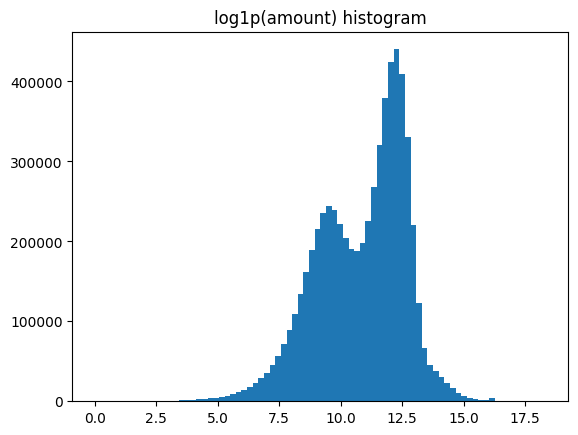

In [ ]:
## amount is highly skewed and large on scale so log transformation applied for modelling
df["log_amount"] = np.log1p(df["amount"])
plt.hist((df['log_amount']), bins=80); plt.title('log1p(amount) histogram'); plt.show()

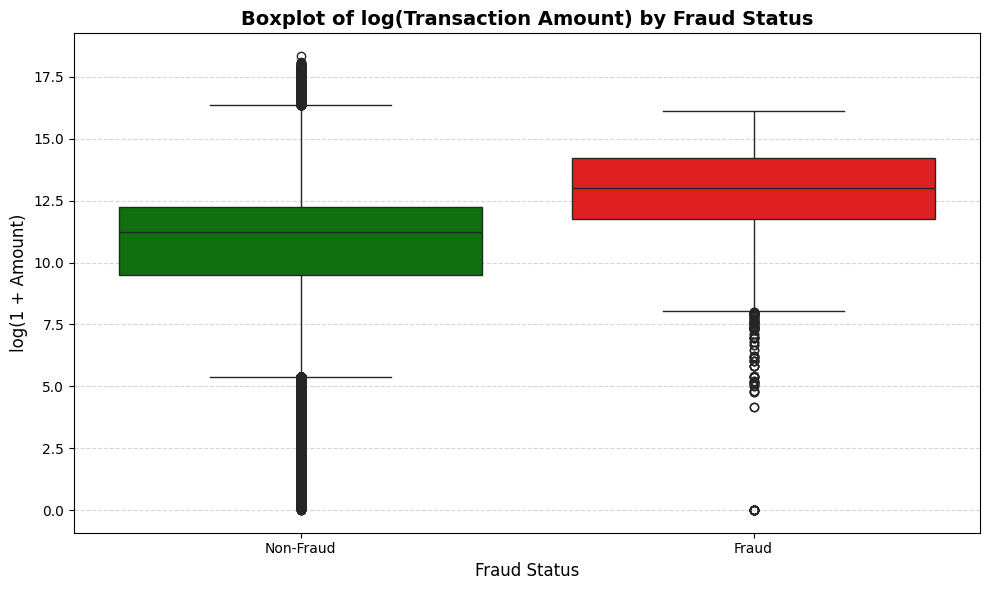

In [ ]:
## let's check wiht fruad vs amount
# Ensure isFraud is string for palette mapping
df['isFraud'] = df['isFraud'].astype(str)

# Log-transform the amount to handle skew
df['log_amount'] = np.log1p(df['amount'])

plt.figure(figsize=(10,6))

# Boxplot
sns.boxplot(x='isFraud', y='log_amount', legend = False, data=df, palette={'0':'green', '1':'red'})


plt.title("Boxplot of log(Transaction Amount) by Fraud Status", fontsize=14, weight='bold')
plt.xlabel("Fraud Status", fontsize=12)
plt.ylabel("log(1 + Amount)", fontsize=12)
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

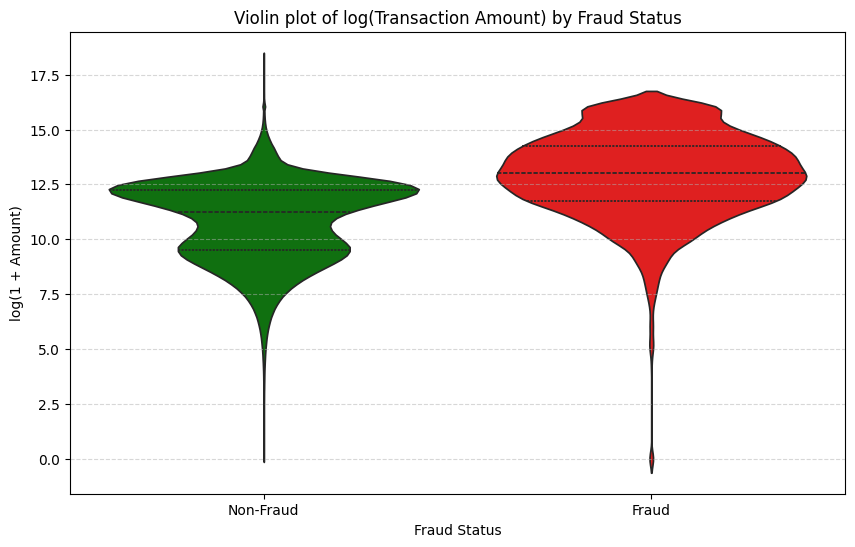

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='isFraud', y='log_amount', data=df, palette={'0':'green','1':'red'}, inner='quartile')
plt.title("Violin plot of log(Transaction Amount) by Fraud Status")
plt.xlabel("Fraud Status")
plt.ylabel("log(1 + Amount)")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
## making target column again integers
df["isFraud"]=df["isFraud"].astype("int8")

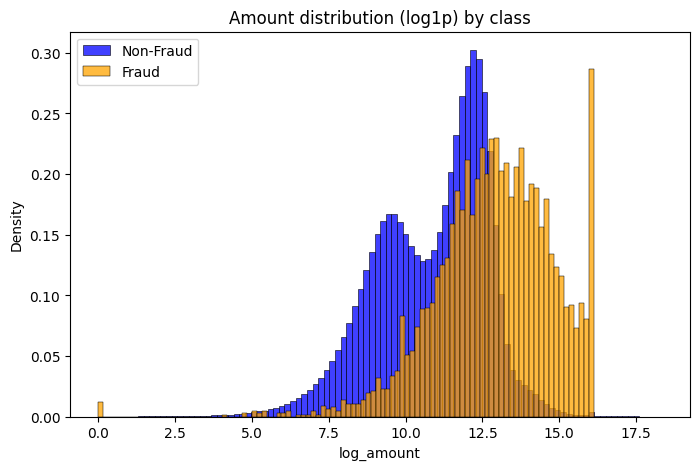

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df.isFraud==0]['log_amount'], color='blue', stat='density', bins=100, label='Non-Fraud')
sns.histplot(df[df.isFraud==1]['log_amount'], color='orange', stat='density', bins=100, label='Fraud')
plt.legend()
plt.title("Amount distribution (log1p) by class")
plt.show()

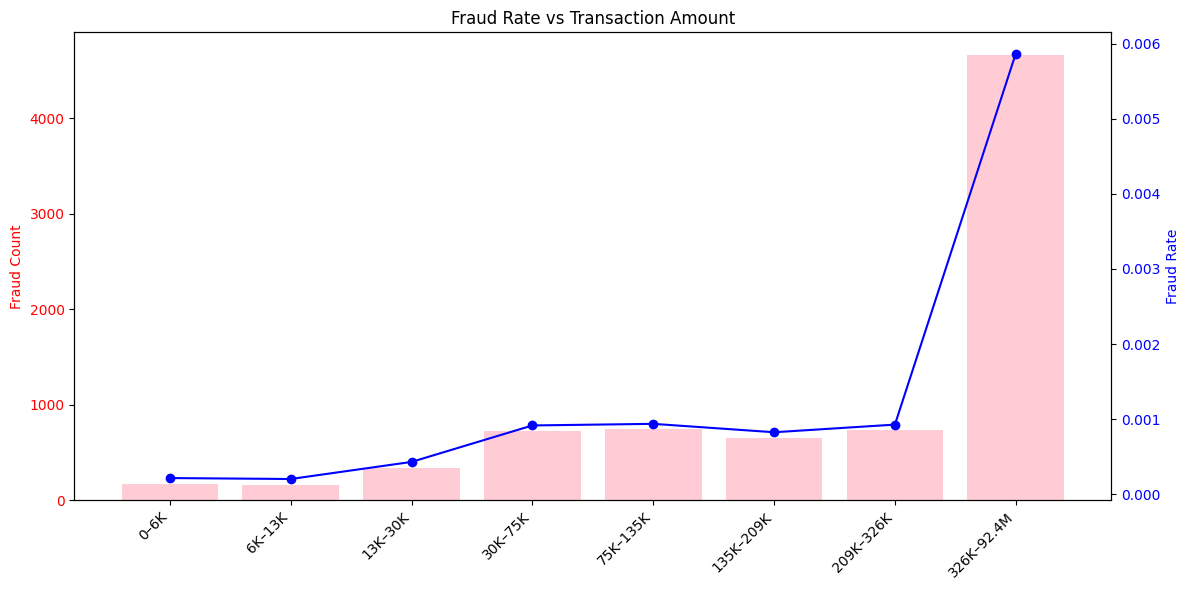

In [ ]:
# Bin transaction amount into 8 quantiles
df["amount_bin"] = pd.qcut(df["amount"], q=8)

# Fraud stats (fraud rate + fraud count)
fraud_stats = df.groupby("amount_bin")["isFraud"].agg(["mean", "sum"]).reset_index()

# Function to convert bin intervals into readable labels
def format_bin_label(interval):
    left, right = interval.left, interval.right
    def fmt(x):
        if x >= 1_000_000:
            return f"{x/1_000_000:.1f}M"
        elif x >= 1_000:
            return f"{x/1000:.0f}K"
        else:
            return str(int(x))
    return f"{fmt(left)}–{fmt(right)}"

# Apply formatting
fraud_stats["bin_label"] = fraud_stats["amount_bin"].apply(format_bin_label)

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot: Fraud Count
ax1.bar(fraud_stats["bin_label"], fraud_stats["sum"],
        color="pink", alpha=0.8, label="Fraud Count")
ax1.set_ylabel("Fraud Count", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Rotate x labels for readability
plt.xticks(rotation=45, ha="right")

# Line plot: Fraud Rate
ax2 = ax1.twinx()
ax2.plot(fraud_stats["bin_label"], fraud_stats["mean"],
         color="blue", marker="o", label="Fraud Rate")
ax2.set_ylabel("Fraud Rate", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Fraud Rate vs Transaction Amount")
plt.tight_layout()
plt.show()

***STEP (TIME)***

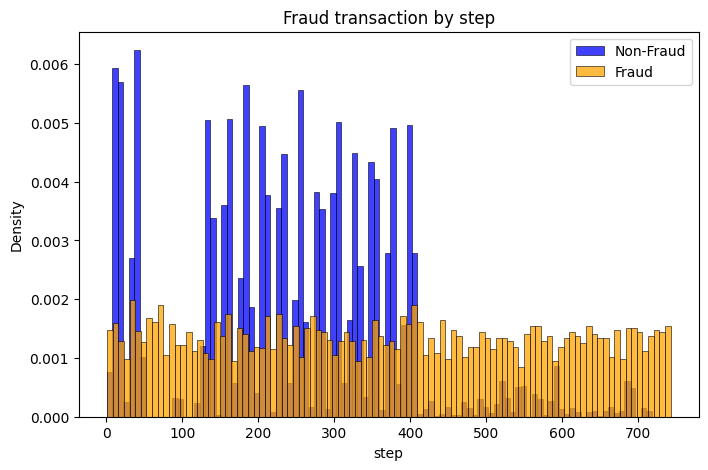

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df.isFraud==0]['step'], color='blue', stat='density', bins=100, label='Non-Fraud')
sns.histplot(df[df.isFraud==1]['step'], color='orange', stat='density', bins=100, label='Fraud')
plt.legend()
plt.title("Fraud transaction by step")
plt.show()

In [ ]:
# Convert step to more useful time features
df["hour"] = df["step"] % 24              # hour of day (0-23)
df["day"] = (df["step"] // 24) % 7        # day of week (0=Monday, 6=Sunday)
df["day_of_month"] = df["step"] // 24     # day index (0–30)

# Weekend flag
df["is_weekend"] = df["day"].isin([5,6]).astype("int8")

# Working hours flag (example: 9am–6pm)
df["is_working_hours"] = df["hour"].between(9,18).astype("int8")

# (Optional) Cyclical encoding for hour-of-day
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# (Optional) Cyclical encoding for day-of-week
df["day_sin"] = np.sin(2 * np.pi * df["day"] / 7)
df["day_cos"] = np.cos(2 * np.pi * df["day"] / 7)

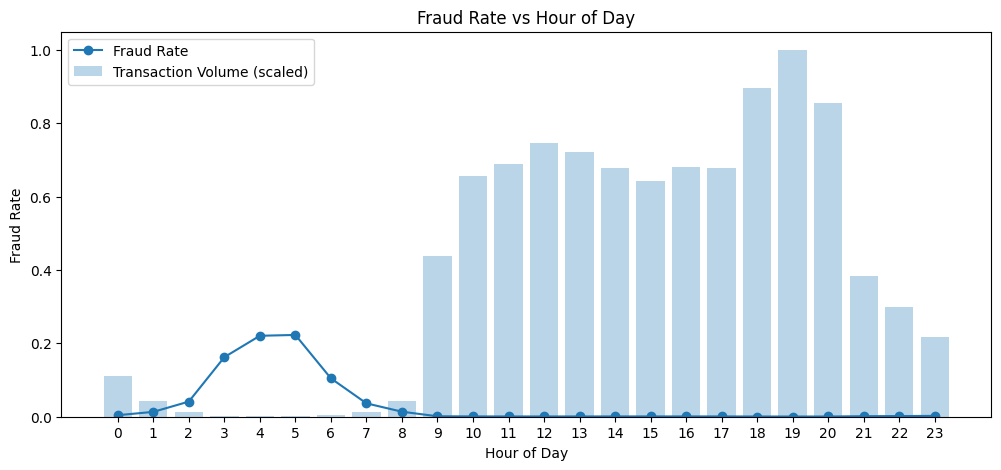

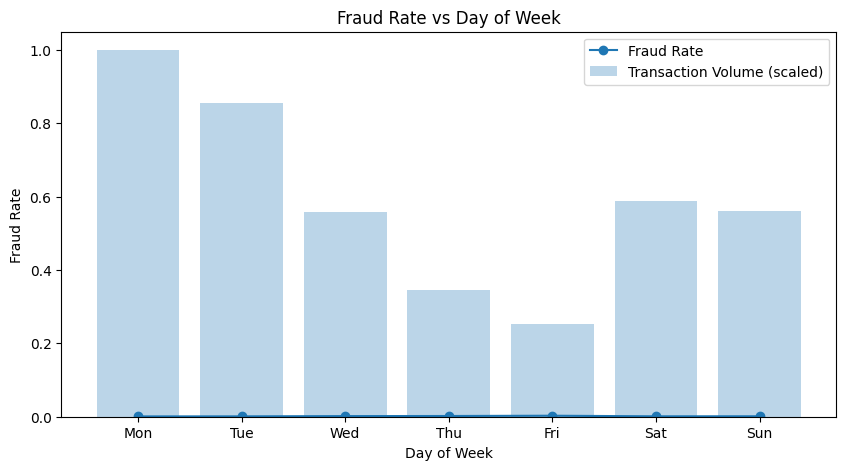

In [ ]:
# Fraud vs non-fraud by hour of day
fraud_by_hour = df.groupby("hour")["isFraud"].mean()
count_by_hour = df.groupby("hour")["isFraud"].count()

plt.figure(figsize=(12,5))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker="o", label="Fraud Rate")
plt.bar(count_by_hour.index, count_by_hour.values/count_by_hour.values.max(),
        alpha=0.3, label="Transaction Volume (scaled)")
plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate vs Hour of Day")
plt.legend()
plt.show()


# Fraud vs non-fraud by day of week
fraud_by_day = df.groupby("day")["isFraud"].mean()
count_by_day = df.groupby("day")["isFraud"].count()

plt.figure(figsize=(10,5))
plt.plot(fraud_by_day.index, fraud_by_day.values, marker="o", label="Fraud Rate")
plt.bar(count_by_day.index, count_by_day.values/count_by_day.values.max(),
        alpha=0.3, label="Transaction Volume (scaled)")
plt.xticks(range(0,7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Day of Week")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate vs Day of Week")
plt.legend()
plt.show()

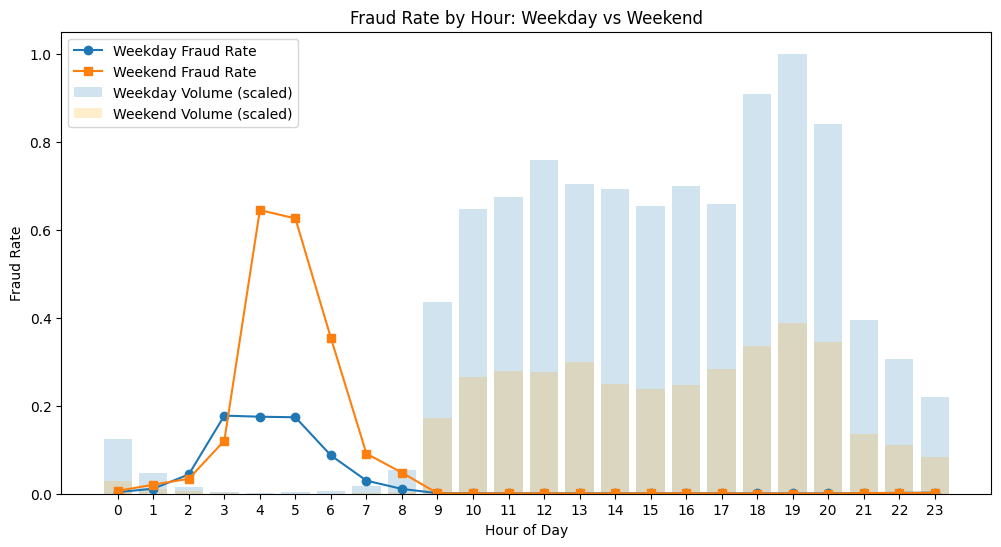

In [ ]:
# Group by weekend flag + hour
fraud_by_hour_weekend = df.groupby(["is_weekend","hour"])["isFraud"].mean().unstack(0)
count_by_hour_weekend = df.groupby(["is_weekend","hour"])["isFraud"].count().unstack(0)

plt.figure(figsize=(12,6))

# Fraud rate lines
plt.plot(fraud_by_hour_weekend.index, fraud_by_hour_weekend[0], marker="o", label="Weekday Fraud Rate")
plt.plot(fraud_by_hour_weekend.index, fraud_by_hour_weekend[1], marker="s", label="Weekend Fraud Rate")

# Overlay scaled transaction volume (just to see traffic levels)
plt.bar(count_by_hour_weekend.index,
        count_by_hour_weekend[0]/count_by_hour_weekend.values.max(),
        alpha=0.2, label="Weekday Volume (scaled)")
plt.bar(count_by_hour_weekend.index,
        count_by_hour_weekend[1]/count_by_hour_weekend.values.max(),
        alpha=0.2, label="Weekend Volume (scaled)", color="orange")

plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Hour: Weekday vs Weekend")
plt.legend()
plt.show()


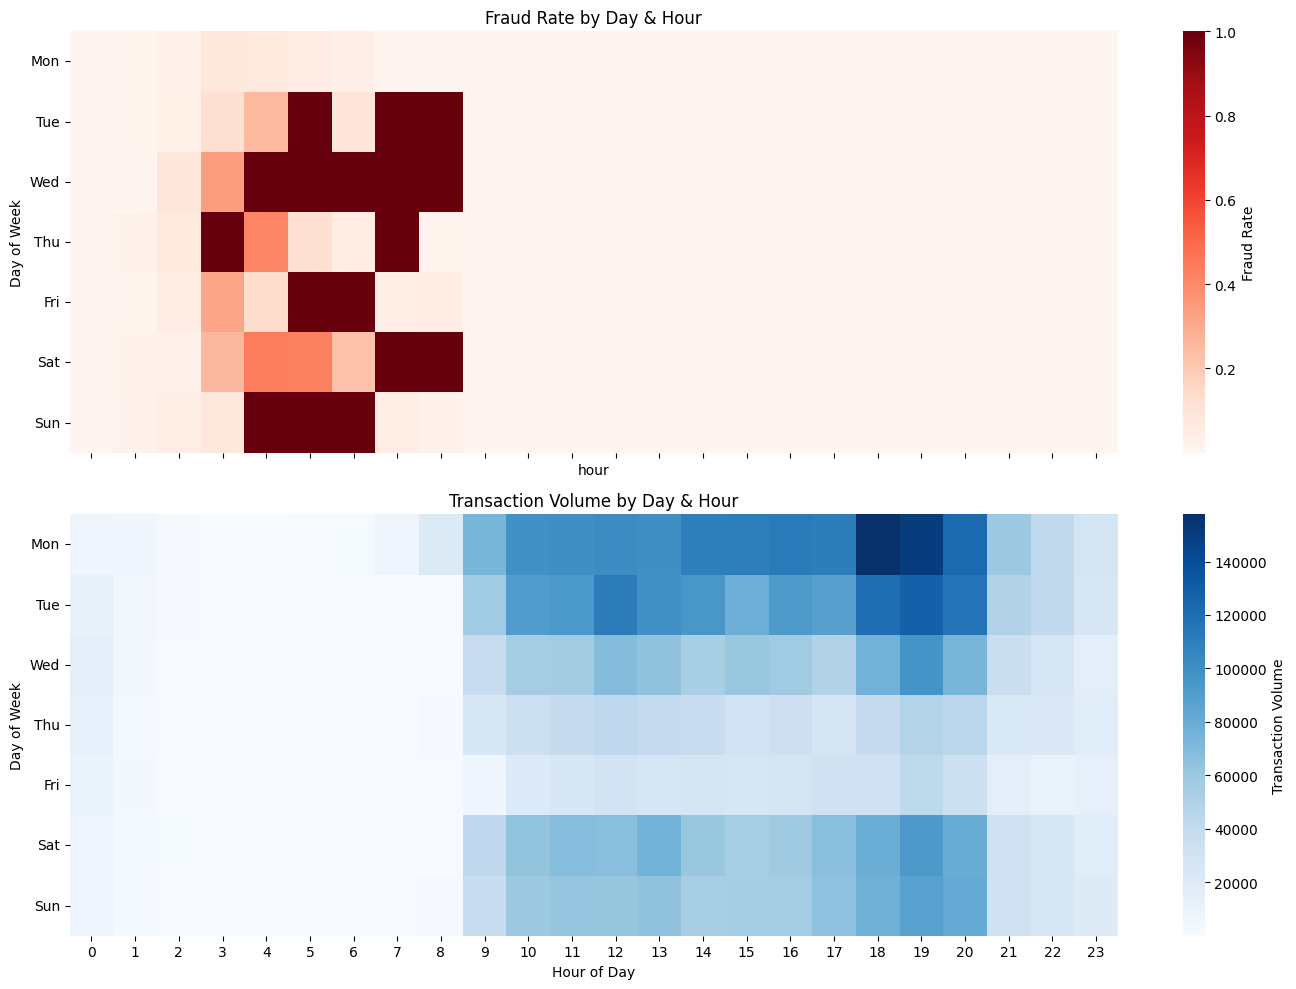

In [ ]:
# Fraud rate heatmap (mean fraud per day-hour)
fraud_heatmap = df.pivot_table(
    values="isFraud",
    index="day",
    columns="hour",
    aggfunc="mean"
)

# Transaction volume heatmap (counts per day-hour)
volume_heatmap = df.pivot_table(
    values="isFraud",
    index="day",
    columns="hour",
    aggfunc="count"
)

# Plot stacked (up and down)
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Fraud rate heatmap
sns.heatmap(fraud_heatmap, cmap="Reds", ax=axes[0], cbar_kws={'label': 'Fraud Rate'})
axes[0].set_title("Fraud Rate by Day & Hour")
axes[0].set_ylabel("Day of Week")
axes[0].set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
axes[0].set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

# Transaction volume heatmap
sns.heatmap(volume_heatmap, cmap="Blues", ax=axes[1], cbar_kws={'label': 'Transaction Volume'})
axes[1].set_title("Transaction Volume by Day & Hour")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Day of Week")
axes[1].set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
axes[1].set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

plt.tight_layout()
plt.show()

## 🕒 Temporal Fraud Insights and Feature Importance

### Key Findings from Plots
- **Fraud vs Hour of Day**
  - Fraud spikes during **2–6 AM**, especially when transaction volume is very low.
  - During normal **working hours (9 AM–6 PM)**, fraud rate drops almost to zero despite high traffic.
- **Fraud vs Day of Week**
  - Fraud rate is **not strongly dependent on day of week** (flat across Mon–Sun).
  - Transaction volume, however, follows a weekly cycle (high Mon–Tue, lowest Fri, moderate Sat–Sun).
- **Weekday vs Weekend**
  - Fraud is even **more concentrated on weekends**, again around 2–5 AM.
  - Weekday fraud also happens in the same early morning window but at slightly lower intensity.
- **Heatmap (Day × Hour)**
  - Fraud “hot zones” appear consistently between **2–7 AM across multiple days**.
  - Daytime hours (business activity) are essentially fraud-free.
  - Confirms fraudsters exploit **low-traffic time windows**.

---

### Recommended Time-Based Features
These engineered features from `step` should help the model capture fraud patterns:

- `hour` → Hour of day (0–23).
- `is_weekend` → Binary flag (1 = Sat/Sun).
- `is_working_hours` → Binary flag (1 = 9 AM–6 PM).
- `hour_sin`, `hour_cos` → Cyclical encoding for hour of day.

---

### Why These Help
- **Hour-based features** capture the strong fraud clustering in early mornings.
- **Weekend flag** captures the increased weekend-night fraud activity.
- **Working hours flag** separates business transactions (low fraud) from odd-hour activity (high fraud).
- **Cyclical encodings** let ML models understand circular time (23:00 is close to 00:00, not far away).

---

✅ In short:  
The **best temporal predictors** for fraud in this dataset will likely be  
`hour`, `is_weekend`, `is_working_hours`, `hour_sin`, `hour_cos`.  
Other columns like `day`, `day_of_month`, `day_sin`, `day_cos` are useful for capturing weekly patterns and residual cycles.

In [ ]:
# Fraud percentage by day
fraud_percent_by_day = (
    df.groupby("day")["isFraud"].mean() * 100
).round(2)  # multiply by 100 to get %
print("Fraud % by day:\n", fraud_percent_by_day)

# If you also want counts + fraud % side by side
fraud_stats_by_day = (
    df.groupby("day")["isFraud"]
    .agg(total="count", fraud_count="sum")
    .assign(fraud_pct=lambda x: (x["fraud_count"] / x["total"] * 100).round(2))
)
print("\nDetailed fraud stats by day:\n", fraud_stats_by_day)


Fraud % by day:
 day
0   0.090
1   0.100
2   0.170
3   0.200
4   0.270
5   0.110
6   0.120
Name: isFraud, dtype: float64

Detailed fraud stats by day:
        total  fraud_count  fraud_pct
day                                 
0    1528439         1309      0.090
1    1308093         1302      0.100
2     854364         1454      0.170
3     527873         1050      0.200
4     387974         1062      0.270
5     898274          996      0.110
6     857603         1040      0.120


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'dest_is_merchant', 'origin_error', 'origin_was_zero',
       'neworig_was_zero', 'dest_error', 'dest_was_zero', 'newdest_was_zero',
       'log_amount', 'amount_bin', 'hour', 'day', 'day_of_month', 'is_weekend',
       'is_working_hours', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'],
      dtype='object')

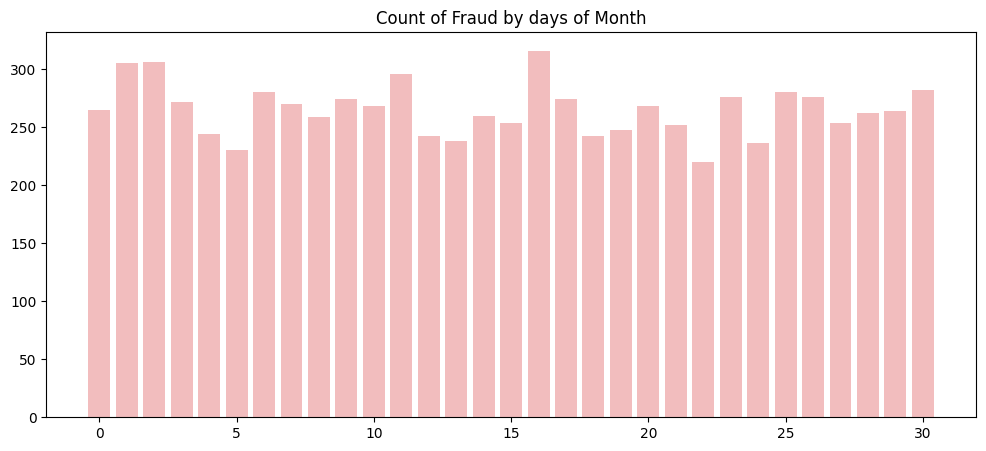

In [ ]:
fraud_counts = df.groupby("day_of_month")["isFraud"].sum()
plt.figure(figsize=(12,5))

plt.bar(fraud_counts.index, fraud_counts.values, alpha=0.3, color="tab:red", label="Fraud Count")
plt.title("Count of Fraud by days of Month")
fig.tight_layout()
plt.show()

***Type***

In [ ]:
fraud_by_type = (
    df.groupby('type',observed=True)['isFraud']
      .agg(count='count', frauds='sum', fraud_rate='mean')
      .sort_values('count', ascending=False)
      .reset_index()
)

# convert to percentage with 5 decimal places
fraud_by_type['fraud_rate'] = (fraud_by_type['fraud_rate'] * 100).round(5).astype(str) + "%"

fraud_by_type

,type,count,frauds,fraud_rate
0,CASH_OUT,2237500,4116,0.18396%
1,PAYMENT,2151495,0,0.0%
2,CASH_IN,1399284,0,0.0%
3,TRANSFER,532909,4097,0.7688%
4,DEBIT,41432,0,0.0%


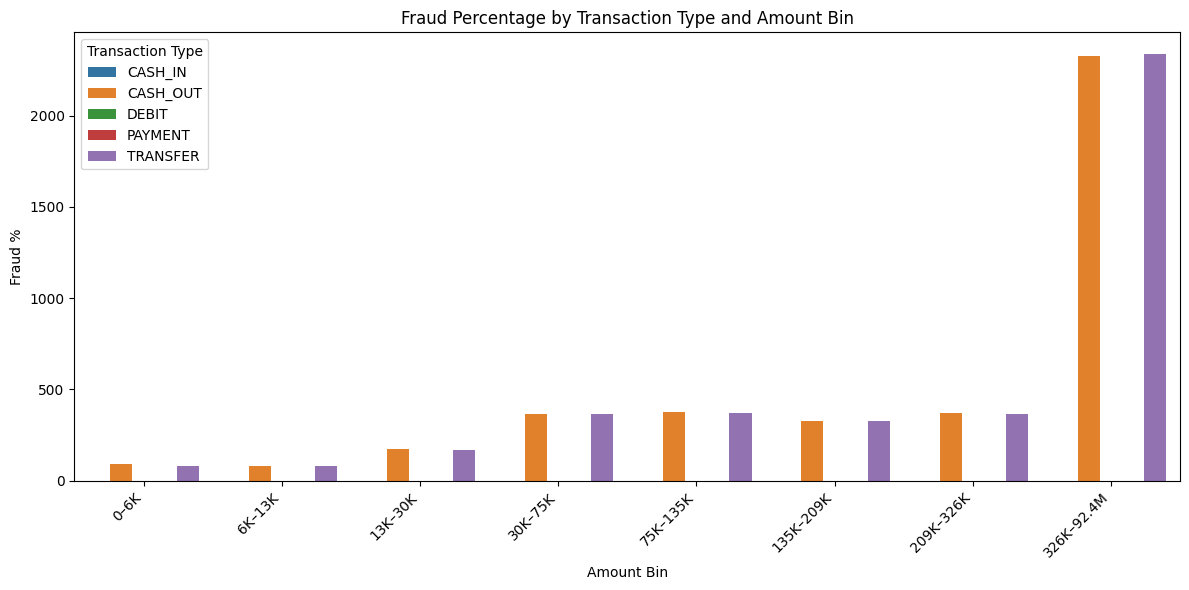

In [ ]:
# Fraud stats (fraud rate + fraud count)
type_fraud_stats = df.groupby(["amount_bin","type"])["isFraud"].sum().reset_index()

# Apply formatting
type_fraud_stats["bin_label"] = type_fraud_stats["amount_bin"].apply(format_bin_label)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=type_fraud_stats,
    x="bin_label", y="isFraud", hue=("type"),dodge="True"
)

plt.title("Fraud Percentage by Transaction Type and Amount Bin")
plt.ylabel("Fraud %")
plt.xlabel("Amount Bin")
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.legend(title="Transaction Type")
plt.tight_layout()
plt.show()

### Fraud Percentage by Transaction Type and Amount Bin

The analysis of fraud percentage across transaction types and amount bins reveals key insights:

- **Fraud is highly concentrated** in **CASH_OUT** and **TRANSFER** transactions.  
- **Higher transaction amounts** (particularly in the **>326K – 2.4M** range) show a sharp increase in fraud percentage.  
- Other transaction types (**CASH_IN, PAYMENT, DEBIT**) contribute almost no fraud cases.  

#### Modeling Implications:
- **Transaction type** (especially CASH_OUT and TRANSFER) is a strong predictor of fraud.  
- **Transaction amount** (or its log-transformed version / binned representation) is also a critical feature.  
- Less informative types (CASH_IN, PAYMENT, DEBIT) may add noise and can potentially be excluded or down-weighted.  

This highlights that fraud detection should focus on **large-value transactions** within the **CASH_OUT** and **TRANSFER** categories.


In [ ]:
# More detailed aggregation of origin_error by fraud status
error_stats = (
    df.groupby("isFraud")["origin_error"]
      .agg([
          "count",          # number of transactions
          "mean",
          "median",
          "std",            # spread
          "min",
          "max",
          "skew",           # skewness
      ])
      .round(2)
)

print(error_stats)


           count        mean     median        std           min   max    skew
isFraud                                                                       
0        6354407 -201338.547 -69049.312 606928.890 -92445520.000 4.000 -30.070
1           8213  -10692.330      0.000 265146.130 -10000000.000 2.000 -31.520


#### Key Observations:
- **Non-fraud transactions**
  - Mean error ≈ **-201K**, median ≈ **-69K**.  
  - Very large negative outliers (as low as -92M) dominate the distribution.  
  - Extremely **left-skewed** (skew = -30.07), meaning heavy tails on the negative side.  

- **Fraudulent transactions**
  - Mean error is much closer to zero (**-10K**), and median is **exactly 0**.  
  - Still shows large negative outliers (down to -10M), but variance is smaller compared to non-fraud.  
  - Also heavily **left-skewed** (skew = -31.52).  

#### Modeling Implications:
- For non-fraud: systematic **negative discrepancies** at the origin account.  
- For fraud: errors often collapse to **0**, suggesting fraud attempts may try to “balance” the origin account.  
- Feature engineering ideas:
  - Use **absolute error** (`abs(origin_error)`) as a cleaner measure of anomaly size.  
  - Create a **binary feature** (e.g., `origin_error == 0`) to capture fraud’s tendency to “zero out” origin balances.  
  - Apply **robust scaling or log transform** (after shifting) to handle extreme outliers.  


In [ ]:
# More detailed aggregation of origin_error by fraud status
error_stats = (
    df.groupby("isFraud")["dest_error"]
      .agg([
          "count",          # number of transactions
          "mean",
          "median",
          "std",            # spread
          "min",
          "max",
          "skew",           # skewness
      ])
      .round(2)
)

print(error_stats)

           count       mean   median         std           min          max  \
isFraud                                                                       
0        4202912  76005.242    0.000  534778.860 -75885720.000 13191235.000   
1           8213 732509.250 2231.460 1867747.990  -8875517.000 10000000.000   

           skew  
isFraud          
0       -42.420  
1         3.520  


### Analysis of `dest_error` by Fraud Status

The `dest_error` variable measures the discrepancy at the **destination account** after a transaction.  
The statistics show a very different pattern between fraud and non-fraud transactions.

#### Key Observations:
- **Non-fraud transactions**
  - Median `dest_error` is exactly **0**, meaning destination balances typically reconcile correctly.  
  - Some extreme negative outliers (down to -75M) lead to very strong **left skew** (skew = -42.4).  

- **Fraudulent transactions**
  - Mean error (~732K) is **much higher** than for non-fraud.  
  - Median is **>0 (≈2.2K)**, suggesting destination balances are systematically inconsistent in fraud cases.  
  - The distribution is **right-skewed** (skew = 3.52), with extreme positive anomalies (up to 10M).  

#### Modeling Implications:
- `dest_error` is a **strong indicator of fraud**.  
  - Non-fraud → balances typically reconcile to 0.  
  - Fraud → frequent positive deviations at the destination account.  
- Suggested feature engineering:
  - Apply **log transformation or robust scaling** to stabilize variance.  
  - Add **binary anomaly flags** (e.g., `abs(dest_error) > 1M`).  
  - Explore interaction with `transaction type` and `amount` for deeper fraud detection power.  


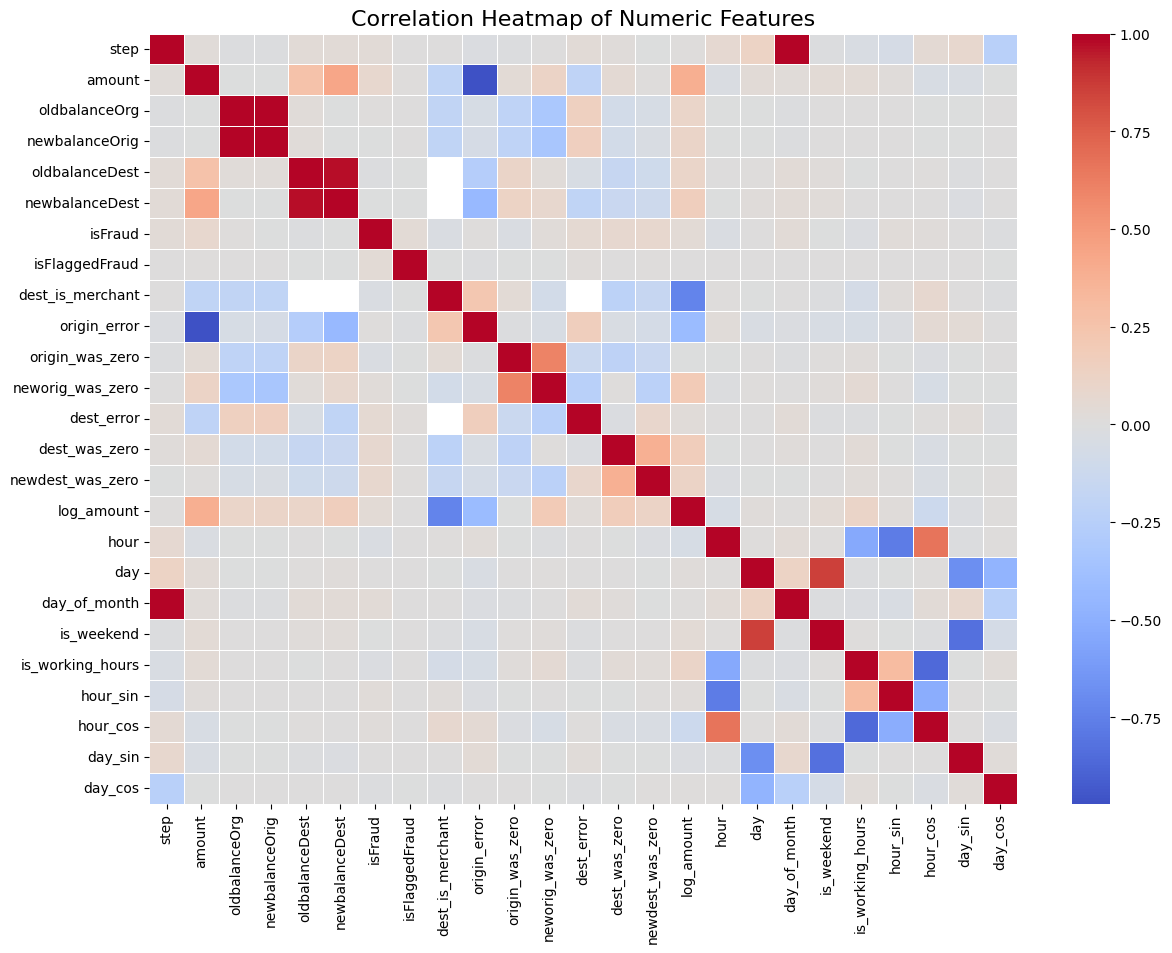

In [ ]:
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=["number"]).columns

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,  # set to True if you want correlation values on the cells
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

In [ ]:
# Correlation of each numeric column with isFraud
fraud_corr = corr["isFraud"].sort_values(key=abs, ascending=False)
print(fraud_corr)

isFraud             1.000
newdest_was_zero    0.078
amount              0.077
dest_was_zero       0.072
dest_error          0.054
isFlaggedFraud      0.044
log_amount          0.041
day_of_month        0.033
step                0.032
hour               -0.031
neworig_was_zero    0.030
hour_sin            0.029
dest_is_merchant   -0.026
origin_was_zero    -0.025
is_working_hours   -0.021
hour_cos            0.017
oldbalanceDest     -0.012
day_cos            -0.012
origin_error        0.011
oldbalanceOrg       0.010
newbalanceOrig     -0.008
newbalanceDest     -0.006
day                 0.005
is_weekend         -0.002
day_sin             0.001
Name: isFraud, dtype: float64


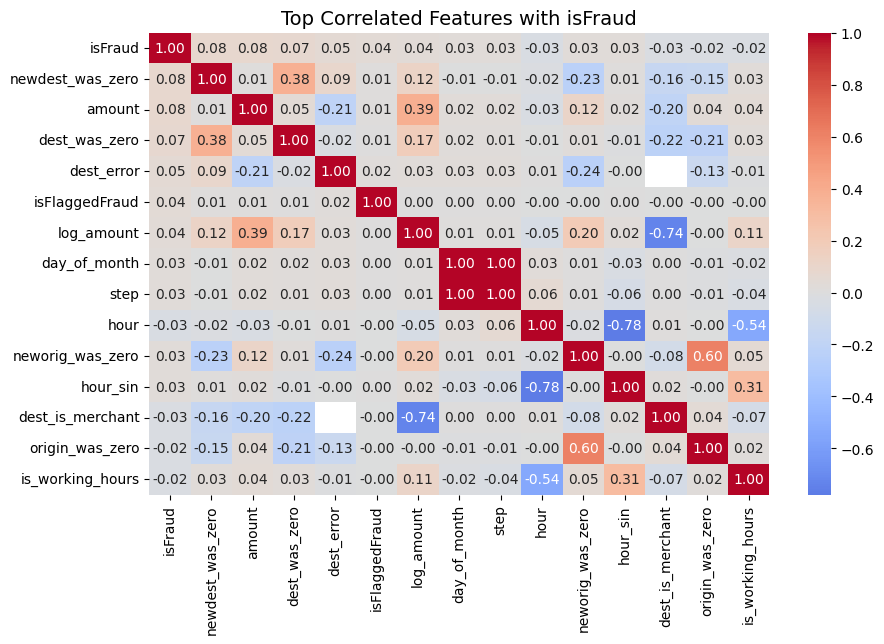

In [ ]:
top_features = fraud_corr.head(15).index  # top 15 correlated
plt.figure(figsize=(10,6))
sns.heatmap(
    corr.loc[top_features, top_features],
    cmap="coolwarm", center=0, annot=True, fmt=".2f"
)
plt.title("Top Correlated Features with isFraud", fontsize=14)
plt.show()

In [ ]:
# threshold for high correlation
threshold = 0.95

# absolute correlation matrix
corr_matrix = df[numeric_cols].corr().abs()

# select upper triangle
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# find columns to drop
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly correlated columns to drop:", to_drop)


Highly correlated columns to drop: ['newbalanceOrig', 'newbalanceDest', 'origin_error', 'day_of_month']


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_is_merchant,origin_error,...,log_amount,hour,day,day_of_month,is_weekend,is_working_hours,hour_sin,hour_cos,day_sin,day_cos
count,6362620.000,6362620.000,6362620.000,6362620.000,4211125.000,4211125.000,6362620.000,6362620.000,6362620.000,6362620.000,...,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000
mean,243.397,179861.922,833883.375,855113.688,1663058.500,1850856.875,0.001,0.000,0.338,-201092.625,...,10.841,15.321,2.482,9.503,0.276,0.696,-0.449,-0.303,0.058,0.261
std,142.332,599135.750,2831752.750,2862818.500,4062421.500,4374467.500,0.036,0.002,0.473,600153.250,...,1.810,4.322,2.165,5.922,0.447,0.460,0.547,0.638,0.703,0.659
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-92445520.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,-0.975,-0.901
25%,156.000,13389.570,0.000,0.000,139659.047,221717.594,0.000,0.000,0.000,-249641.125,...,9.502,12.000,1.000,6.000,0.000,0.000,-0.966,-0.866,-0.782,-0.223
50%,239.000,74871.938,14208.000,0.000,551247.188,683724.812,0.000,0.000,0.000,-68677.254,...,11.224,16.000,2.000,9.000,0.000,1.000,-0.707,-0.500,0.000,0.623
75%,335.000,208721.480,107315.176,144258.406,1692950.875,1910978.500,0.000,0.000,1.000,-2954.197,...,12.249,19.000,5.000,13.000,1.000,1.000,0.000,0.259,0.782,0.623
max,743.000,92445520.000,59585040.000,49585040.000,356015904.000,356179264.000,1.000,1.000,1.000,4.000,...,18.342,23.000,6.000,30.000,1.000,1.000,1.000,1.000,0.975,1.000


In [ ]:
df["amount_bin"]

,amount_bin
0,"(5711.688, 13389.57]"
1,"(-0.001, 5711.688]"
2,"(-0.001, 5711.688]"
3,"(-0.001, 5711.688]"
4,"(5711.688, 13389.57]"
...,...
6362615,"(325987.375, 92445520.0]"
6362616,"(325987.375, 92445520.0]"
6362617,"(325987.375, 92445520.0]"
6362618,"(325987.375, 92445520.0]"


In [ ]:
df[["oldbalanceDest", "newbalanceDest"]] = df[["oldbalanceDest", "newbalanceDest"]].fillna(0)

# DATA PREPROCESSING

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# -----------------
# 1. Target + drop
# -----------------
y = df["isFraud"].astype("int8")

drop_cols = [
    "amount", "hour", "day", "day_of_month", "amount_bin",
    "newbalanceOrig", "newbalanceDest", "isFlaggedFraud" # Remove isFlaggedFraud due to low variance and redundancy
]
X = df.drop(columns=drop_cols + ["isFraud"], errors="ignore").copy()

# -----------------
# 2. Define column groups
# -----------------
# Handle amount_bin as categorical
categorical_cols = ["type"]
log_cols = ["oldbalanceOrg", "oldbalanceDest", "log_amount"]

# Handle origin_error and dest_error separately with absolute value
error_cols = ["origin_error", "dest_error"]

nonlog_cols = ["step"]

# binary flags (all int8 columns incl. dest_is_merchant)
binary_flags = [
    "origin_was_zero", "neworig_was_zero",
    "dest_was_zero", "newdest_was_zero", "is_weekend", "is_working_hours",
    "dest_is_merchant"
]

# Cyclical features - handled as passthrough
cyclic_cols = ["hour_sin", "hour_cos", "day_sin", "day_cos"]

# Columns that might contain NaNs after feature engineering
cols_with_nans = ["oldbalanceDest", "newbalanceDest", "dest_error"]

# -----------------
# 3. Preprocessor
# -----------------
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_cols),

        ("numeric_log", Pipeline([
            ("log", FunctionTransformer(np.log1p, validate=False)),
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)), # Impute NaNs with 0 after log transformation
            ("scale", RobustScaler())
        ]), log_cols),

        # Apply RobustScaler to absolute values of error columns
        ("error_scaling", Pipeline([
            ("abs", FunctionTransformer(np.abs, validate=False)),
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)), # Impute NaNs with 0 after abs transformation
            ("scale", RobustScaler())
        ]), error_cols),

        ("numeric_step", RobustScaler(), nonlog_cols),

        ("passthrough", "passthrough", cyclic_cols + binary_flags),
    ],
    remainder="drop"
)

# -----------------
# 4. Train-test split
# -----------------
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your dataset is df and target column is 'isFraud'
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# 1️⃣ First split: train vs temp (train 70%, temp 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 2️⃣ Second split: validation vs test from temp (each 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Check sizes
print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

# Check target distribution
print("\nTrain target distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation target distribution:\n", y_val.value_counts(normalize=True))
print("\nTest target distribution:\n", y_test.value_counts(normalize=True))


# -----------------
# 5. Transform data
# -----------------
# Fit preprocessor on train, transform train, validation, and test
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)    # <-- transform validation
X_test_transformed = preprocessor.transform(X_test)

# Print shapes
print("Train shape:", X_train_transformed.shape)
print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)


Train set: (4453834, 26)
Validation set: (954393, 26)
Test set: (954393, 26)

Train target distribution:
 isFraud
0   0.999
1   0.001
Name: proportion, dtype: float64

Validation target distribution:
 isFraud
0   0.999
1   0.001
Name: proportion, dtype: float64

Test target distribution:
 isFraud
0   0.999
1   0.001
Name: proportion, dtype: float64
Train shape: (4453834, 21)
Validation shape: (954393, 21)
Test shape: (954393, 21)


# **LOGISTIC REGRESSION**

In [ ]:
## import model libraries
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

In [ ]:
# -----------------
# Step 1: Train logistic regression on training set
# -----------------
log_reg = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",  # handle imbalance
    random_state=42
)

log_reg.fit(X_train_transformed, y_train)

# -----------------
# Step 2: Predict on validation set
# -----------------
y_val_proba = log_reg.predict_proba(X_val_transformed)[:, 1]  # probabilities
threshold = 0.5  # default threshold
y_val_pred = (y_val_proba >= threshold).astype(int)           # predicted classes

# -----------------
# Step 3: Evaluate performance on validation set
# -----------------
print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

Validation Set Metrics:
              precision    recall  f1-score   support

           0     1.0000    0.9741    0.9869    953161
           1     0.0471    0.9911    0.0900      1232

    accuracy                         0.9741    954393
   macro avg     0.5236    0.9826    0.5384    954393
weighted avg     0.9988    0.9741    0.9857    954393

Confusion Matrix:
 [[928469  24692]
 [    11   1221]]
ROC-AUC: 0.9976339032924175


In [ ]:
# -----------------
# Predict probabilities for train and validation
# -----------------
y_train_proba = log_reg.predict_proba(X_train_transformed)[:, 1]
y_val_proba = log_reg.predict_proba(X_val_transformed)[:, 1]

# Try multiple thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    print(f"\n--- Threshold = {t:.2f} ---")

    # Train set metrics
    y_train_pred = (y_train_proba >= t).astype(int)
    print("Train Set Classification Report:")
    print(classification_report(y_train, y_train_pred, digits=4))
    print("Train Set Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

    # Validation set metrics
    y_val_pred = (y_val_proba >= t).astype(int)
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, y_val_pred, digits=4))
    print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))



--- Threshold = 0.10 ---
Train Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9335    0.9656   4448085
           1     0.0190    0.9962    0.0373      5749

    accuracy                         0.9335   4453834
   macro avg     0.5095    0.9648    0.5014   4453834
weighted avg     0.9987    0.9335    0.9644   4453834

Train Set Confusion Matrix:
 [[4152136  295949]
 [     22    5727]]

Validation Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9333    0.9655    953161
           1     0.0190    0.9976    0.0372      1232

    accuracy                         0.9334    954393
   macro avg     0.5095    0.9654    0.5014    954393
weighted avg     0.9987    0.9334    0.9643    954393

Validation Set Confusion Matrix:
 [[889587  63574]
 [     3   1229]]

--- Threshold = 0.15 ---
Train Set Classification Report:
              precision    recall  f1-score   suppor

In [ ]:
best_f1 = 0
best_threshold = 0.5
for t in thresholds:
    y_val_pred = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best threshold:", best_threshold)
print("F1 at best threshold:", best_f1)


Best threshold: 0.8500000000000002
F1 at best threshold: 0.2845937002083589


In [ ]:
# -----------------
# Combine train + validation for final training
# -----------------
# Combine features
X_full_train = np.vstack([X_train_transformed, X_val_transformed])
y_full_train = np.hstack([y_train, y_val])

# Fit model on full training data
final_model = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    random_state=42
)
final_model.fit(X_full_train, y_full_train)

# Predict probabilities on test set
y_test_proba = final_model.predict_proba(X_test_transformed)[:, 1]

# Apply best threshold
best_threshold = 0.85
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Evaluate performance on test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Test Set ROC-AUC:", roc_auc_score(y_test, y_test_proba))

Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9941    0.9970    953161
           1     0.1706    0.9318    0.2884      1232

    accuracy                         0.9941    954393
   macro avg     0.5853    0.9630    0.6427    954393
weighted avg     0.9988    0.9941    0.9961    954393

Test Set Confusion Matrix:
[[947580   5581]
 [    84   1148]]
Test Set ROC-AUC: 0.9974274524995755


# **LightGBM**

In [ ]:
# -----------------
# 1. Initialize LightGBM Classifier
# -----------------
lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    is_unbalance=True,  # handle class imbalance
    random_state=42,
    n_estimators=500,   # Increase estimators for better performance
    learning_rate=0.05  # Slightly lower learning rate
)

# -----------------
# 2. Train on training set
# -----------------
lgbm.fit(X_train_transformed, y_train)

print("LightGBM model trained successfully.")

# -----------------
# 3. Evaluate on training set
# -----------------
y_train_pred = lgbm.predict(X_train_transformed)
y_train_proba = lgbm.predict_proba(X_train_transformed)[:, 1]

print("Train Set Classification Report:")
print(classification_report(y_train, y_train_pred, digits=4))
print("Train Set Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Train Set ROC-AUC:", roc_auc_score(y_train, y_train_proba))

# -----------------
# 4. Evaluate on validation set
# -----------------
y_val_pred = lgbm.predict(X_val_transformed)
y_val_proba = lgbm.predict_proba(X_val_transformed)[:, 1]

print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation Set ROC-AUC:", roc_auc_score(y_val, y_val_proba))

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.802275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [ ]:
# Predict probabilities for train and validation sets
y_train_proba = lgbm.predict_proba(X_train_transformed)[:, 1]
y_val_proba = lgbm.predict_proba(X_val_transformed)[:, 1]

# Define thresholds to test
thresholds = np.arange(0.1, 0.95, 0.05)

best_f1 = 0
best_threshold = 0.5  # default

for t in thresholds:
    # Train set predictions
    y_train_pred = (y_train_proba >= t).astype(int)
    print(f"\n--- Threshold = {t:.2f} ---")
    print("Train Set Classification Report:")
    print(classification_report(y_train, y_train_pred, digits=4))
    print("Train Set Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

    # Validation set predictions
    y_val_pred = (y_val_proba >= t).astype(int)
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, y_val_pred, digits=4))
    print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

    # Track best threshold based on F1-score for class 1 (fraud)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nBest Threshold based on validation F1-score:", best_threshold)
print("F1-score at best threshold:", best_f1)


--- Threshold = 0.10 ---
Train Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9930    0.9965   4448085
           1     0.1538    0.9910    0.2662      5749

    accuracy                         0.9929   4453834
   macro avg     0.5769    0.9920    0.6313   4453834
weighted avg     0.9989    0.9929    0.9955   4453834

Train Set Confusion Matrix:
 [[4416734   31351]
 [     52    5697]]

Validation Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964    953161
           1     0.1525    0.9886    0.2643      1232

    accuracy                         0.9929    954393
   macro avg     0.5763    0.9908    0.6303    954393
weighted avg     0.9989    0.9929    0.9955    954393

Validation Set Confusion Matrix:
 [[946393   6768]
 [    14   1218]]

--- Threshold = 0.15 ---
Train Set Classification Report:
              precision    recall  f1-score   suppor

# **Xgboost**

In [ ]:
# -----------------
# 1. Initialize XGBoost Classifier
# -----------------
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # handle imbalance
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# -----------------
# 2. Train on training set
# -----------------
xgb_model.fit(X_train_transformed, y_train)

print("XGBoost model trained successfully.")

# -----------------
# 3. Evaluate on training set
# -----------------
y_train_pred = xgb_model.predict(X_train_transformed)
y_train_proba = xgb_model.predict_proba(X_train_transformed)[:, 1]

print("Train Set Classification Report:")
print(classification_report(y_train, y_train_pred, digits=4))
print("Train Set Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Train Set ROC-AUC:", roc_auc_score(y_train, y_train_proba))

# -----------------
# 4. Evaluate on validation set
# -----------------
y_val_pred = xgb_model.predict(X_val_transformed)
y_val_proba = xgb_model.predict_proba(X_val_transformed)[:, 1]

print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation Set ROC-AUC:", roc_auc_score(y_val, y_val_proba))

XGBoost model trained successfully.
Train Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   4448085
           1     0.9993    1.0000    0.9997      5749

    accuracy                         1.0000   4453834
   macro avg     0.9997    1.0000    0.9998   4453834
weighted avg     1.0000    1.0000    1.0000   4453834

Train Set Confusion Matrix:
 [[4448081       4]
 [      0    5749]]
Train Set ROC-AUC: 0.9999999999804474

Validation Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    953161
           1     0.9968    0.9968    0.9968      1232

    accuracy                         1.0000    954393
   macro avg     0.9984    0.9984    0.9984    954393
weighted avg     1.0000    1.0000    1.0000    954393

Validation Set Confusion Matrix:
 [[953157      4]
 [     4   1228]]
Validation Set ROC-AUC: 0.999703444456318


In [ ]:
# Predicted probabilities for train and validation
y_train_proba = xgb_model.predict_proba(X_train_transformed)[:, 1]
y_val_proba = xgb_model.predict_proba(X_val_transformed)[:, 1]

thresholds = np.arange(0.1, 0.95, 0.05)
best_f1 = 0
best_threshold = 0.5  # default

for t in thresholds:
    # Train set predictions
    y_train_pred = (y_train_proba >= t).astype(int)

    # Validation set predictions
    y_val_pred = (y_val_proba >= t).astype(int)

    # Track best threshold based on F1-score for fraud class (1)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

    # Optional: print metrics
    print(f"\nThreshold = {t:.2f}")
    print("Validation F1-score:", f1)
    print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

print("\nBest Threshold based on validation F1-score:", best_threshold)
print("F1-score at best threshold:", best_f1)


Threshold = 0.10
Validation F1-score: 0.9895245769540693
Validation Confusion Matrix:
 [[953139     22]
 [     4   1228]]

Threshold = 0.15
Validation F1-score: 0.9923232323232323
Validation Confusion Matrix:
 [[953146     15]
 [     4   1228]]

Threshold = 0.20
Validation F1-score: 0.9931257581884351
Validation Confusion Matrix:
 [[953148     13]
 [     4   1228]]

Threshold = 0.25
Validation F1-score: 0.994331983805668
Validation Confusion Matrix:
 [[953151     10]
 [     4   1228]]

Threshold = 0.30
Validation F1-score: 0.9947347104090725
Validation Confusion Matrix:
 [[953152      9]
 [     4   1228]]

Threshold = 0.35
Validation F1-score: 0.9951377633711507
Validation Confusion Matrix:
 [[953153      8]
 [     4   1228]]

Threshold = 0.40
Validation F1-score: 0.9963488843813387
Validation Confusion Matrix:
 [[953156      5]
 [     4   1228]]

Threshold = 0.45
Validation F1-score: 0.9963488843813387
Validation Confusion Matrix:
 [[953156      5]
 [     4   1228]]

Threshold = 0.50

In [ ]:
# -----------------
# 1. Combine train + validation sets
# -----------------
X_train_full = np.vstack([X_train_transformed, X_val_transformed])
y_train_full = np.hstack([y_train, y_val])

# -----------------
# 2. Initialize XGBoost Classifier
# -----------------
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=(len(y_train_full) - sum(y_train_full.astype(np.int64))) / sum(y_train_full.astype(np.int64)), # Convert to int64 before summing
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# -----------------
# 3. Train on full data
# -----------------
xgb_model_final.fit(X_train_full, y_train_full)
print("XGBoost final model trained on train + validation sets.")

# -----------------
# 4. Evaluate on full training data
# -----------------
y_train_full_proba = xgb_model_final.predict_proba(X_train_full)[:, 1]
best_threshold = 0.9
y_train_full_pred = (y_train_full_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nTrain Full Set Classification Report:")
print(classification_report(y_train_full, y_train_full_pred, digits=4))

print("Train Full Set Confusion Matrix:")
print(confusion_matrix(y_train_full, y_train_full_pred))

print("Train Full Set ROC-AUC:", roc_auc_score(y_train_full, y_train_full_proba))

# -----------------
# 5. Predict and evaluate on test set
# -----------------
y_test_proba = xgb_model_final.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Test Set ROC-AUC:", roc_auc_score(y_test, y_test_proba))

XGBoost final model trained on train + validation sets.

Train Full Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   5401246
           1     0.9994    1.0000    0.9997      6981

    accuracy                         1.0000   5408227
   macro avg     0.9997    1.0000    0.9999   5408227
weighted avg     1.0000    1.0000    1.0000   5408227

Train Full Set Confusion Matrix:
[[5401242       4]
 [      0    6981]]
Train Full Set ROC-AUC: 0.9999999998143536

Test Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    953161
           1     0.9976    0.9959    0.9968      1232

    accuracy                         1.0000    954393
   macro avg     0.9988    0.9980    0.9984    954393
weighted avg     1.0000    1.0000    1.0000    954393

Test Set Confusion Matrix:
[[953158      3]
 [     5   1227]]
Test Set ROC-AUC: 0.9998521133140901


# **Random Forest**

In [ ]:
# -----------------
# 1. Import and initialize Random Forest
# -----------------
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',  # handle class imbalance
    random_state=42,
    n_jobs=-1
)

# -----------------
# 2. Train on train set
# -----------------
rf_model.fit(X_train_transformed, y_train)
print("Random Forest model trained on training set.")

# -----------------
# 3. Evaluate on train set (threshold = 0.5)
# -----------------
y_train_pred = rf_model.predict(X_train_transformed)
y_train_proba = rf_model.predict_proba(X_train_transformed)[:, 1]

print("\nTrain Set Classification Report:")
print(classification_report(y_train, y_train_pred, digits=4))
print("Train Set Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Train Set ROC-AUC:", roc_auc_score(y_train, y_train_proba))

# -----------------
# 4. Evaluate on validation set (threshold = 0.5)
# -----------------
y_val_pred = rf_model.predict(X_val_transformed)
y_val_proba = rf_model.predict_proba(X_val_transformed)[:, 1]

print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("Validation Set ROC-AUC:", roc_auc_score(y_val, y_val_proba))


Random Forest model trained on training set.

Train Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   4448085
           1     1.0000    1.0000    1.0000      5749

    accuracy                         1.0000   4453834
   macro avg     1.0000    1.0000    1.0000   4453834
weighted avg     1.0000    1.0000    1.0000   4453834

Train Set Confusion Matrix:
[[4448085       0]
 [      0    5749]]
Train Set ROC-AUC: 1.0

Validation Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    953161
           1     1.0000    0.9968    0.9984      1232

    accuracy                         1.0000    954393
   macro avg     1.0000    0.9984    0.9992    954393
weighted avg     1.0000    1.0000    1.0000    954393

Validation Set Confusion Matrix:
[[953161      0]
 [     4   1228]]
Validation Set ROC-AUC: 0.9991833619072027


In [ ]:
# Predict probabilities
y_train_proba = rf_model.predict_proba(X_train_transformed)[:, 1]
y_val_proba = rf_model.predict_proba(X_val_transformed)[:, 1]

# Define thresholds
thresholds = np.arange(0.1, 0.95, 0.05)

best_threshold = 0.5
best_val_f1 = 0

print("Threshold Analysis:")

for t in thresholds:
    # Binarize predictions based on threshold
    y_train_pred = (y_train_proba >= t).astype(int)
    y_val_pred = (y_val_proba >= t).astype(int)

    # Compute F1-scores
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"\nThreshold = {t:.2f}")
    print(f"Train F1-score: {train_f1:.4f}")
    print(f"Validation F1-score: {val_f1:.4f}")

    # Track best threshold based on validation F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_threshold = t

print(f"\nBest Threshold based on Validation F1-score: {best_threshold}")
print(f"Validation F1-score at best threshold: {best_val_f1:.4f}")


Threshold Analysis:

Threshold = 0.10
Train F1-score: 0.9997
Validation F1-score: 0.9947

Threshold = 0.15
Train F1-score: 0.9999
Validation F1-score: 0.9972

Threshold = 0.20
Train F1-score: 1.0000
Validation F1-score: 0.9980

Threshold = 0.25
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.30
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.35
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.40
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.45
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.50
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.55
Train F1-score: 1.0000
Validation F1-score: 0.9984

Threshold = 0.60
Train F1-score: 0.9997
Validation F1-score: 0.9984

Threshold = 0.65
Train F1-score: 0.9985
Validation F1-score: 0.9980

Threshold = 0.70
Train F1-score: 0.9980
Validation F1-score: 0.9976

Threshold = 0.75
Train F1-score: 0.9979
Validation F1-score: 0.9955

Threshold = 0

In [ ]:
# -----------------
# 1. Combine train + validation sets
# -----------------

X_full_train = np.vstack([X_train_transformed, X_val_transformed])
y_full_train = np.hstack([y_train, y_val])

# -----------------
# 2. Train Random Forest on full training set
# -----------------
rf_final = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_full_train, y_full_train)
print("Random Forest final model trained on train + validation sets.\n")

# -----------------
# 3. Predict on full train set
# -----------------
y_full_train_proba = rf_final.predict_proba(X_full_train)[:, 1]
best_threshold = 0.25
y_full_train_pred = (y_full_train_proba >= best_threshold).astype(int)

print("Train Full Set Classification Report:")
print(classification_report(y_full_train, y_full_train_pred, digits=4))

print("Train Full Set Confusion Matrix:")
print(confusion_matrix(y_full_train, y_full_train_pred))

print("Train Full Set ROC-AUC:", roc_auc_score(y_full_train, y_full_train_proba))

# -----------------
# 4. Predict on test set
# -----------------
y_test_proba = rf_final.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("Test Set ROC-AUC:", roc_auc_score(y_test, y_test_proba))

Random Forest final model trained on train + validation sets.

Train Full Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   5401246
           1     1.0000    1.0000    1.0000      6981

    accuracy                         1.0000   5408227
   macro avg     1.0000    1.0000    1.0000   5408227
weighted avg     1.0000    1.0000    1.0000   5408227

Train Full Set Confusion Matrix:
[[5401246       0]
 [      0    6981]]
Train Full Set ROC-AUC: 1.0

Test Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    953161
           1     0.9992    0.9959    0.9976      1232

    accuracy                         1.0000    954393
   macro avg     0.9996    0.9980    0.9988    954393
weighted avg     1.0000    1.0000    1.0000    954393

Test Set Confusion Matrix:
[[953160      1]
 [     5   1227]]
Test Set ROC-AUC: 0.9979647032314092


# 📊 Model Performance Summary

We evaluated multiple models for fraud detection: **Logistic Regression, XGBoost, LightGBM, and Random Forest.**
Each model was compared on **Precision, Recall, F1-score, and ROC-AUC** across training, validation, and test sets.

---

## 🔹 1. Logistic Regression (Baseline)

* **Strengths:** Simple, interpretable, useful as a benchmark.
* **Weaknesses:** Recall very high but precision extremely low → too many false alarms.
* **Use Case:** Not practical for deployment, but highlighted the challenge of **class imbalance**.

---

## 🔹 2. XGBoost

* **Strengths:** Strong gradient boosting performance, well-calibrated after threshold tuning.
* **Performance:**
  * Train F1 ≈ **0.999**
  * Validation/Test F1 ≈ **0.996**
  * ROC-AUC ≈ **0.999**
* **Use Case:** High-performance candidate, slightly riskier on overfitting due to perfect training scores.

---

## 🔹 3. LightGBM

* **Strengths:** Faster training than XGBoost, similar predictive performance.
* **Weaknesses:** Recall very high but precision extremely low → too many false alarms.
* **Use Case:** Excellent alternative to XGBoost, especially when **speed and scalability** are crucial.

---

## 🔹 4. Random Forest (Final Model)

* **Strengths:** Stable, robust, highly interpretable through feature importance.
* **Performance (Threshold = 0.25):**

  * Train F1 = **1.0**
  * Test F1 = **0.997**, ROC-AUC = **0.997**
  * Only **5 frauds missed** out of 1,232 and **1 false positive** out of 953,161 transactions in test set.
* **Use Case:** Best tradeoff between precision & recall, chosen as **final production model**.

---

## 🚀 Final Takeaway

* **Logistic Regression** → Too many false alarms.
* **XGBoost / LightGBM** → Excellent fraud detection, scalable, high precision-recall balance.
* **Random Forest** → Most stable and interpretable, nearly perfect detection → **Selected as final model**.


## 1. Data Cleaning

Based on the notebook, the following data cleaning steps were performed:

*   **Missing Values:** The `oldbalanceDest` and `newbalanceDest` columns contained missing values (33.815%). These were imputed with **0**. The `dest_error` column also contained the same number of NaNs, which were implicitly handled during the imputation of the balance columns and explicitly by using a SimpleImputer with a constant fill value of 0 after applying the absolute value transformation in the preprocessing pipeline.
*   **Outliers:** While not explicitly removed, the presence of outliers in features like `amount`, `origin_error`, and `dest_error` was noted in the EDA. The preprocessing step addressed this by:
    *   Applying a **log transformation (`np.log1p`)** to `amount` and balance columns to reduce the impact of large values and skewness.
    *   Applying an **absolute value transformation (`np.abs`)** to the error columns (`origin_error`, `dest_error`) to focus on the magnitude of the discrepancy.
    *   Using **RobustScaler** on numeric features, which is less sensitive to outliers compared to standard scaling.
*   **Multicollinearity:** Multicollinearity among numeric features was checked using a correlation heatmap. Highly correlated columns (correlation > 0.95) identified were `newbalanceOrig`, `newbalanceDest`, `origin_error`, and `day_of_month`. Some of these were handled by dropping them in the model training step. Note that `origin_error` was not dropped initially and was kept in the model. `newbalanceDest` was imputed and then dropped, while `oldbalanceDest` was imputed and kept.

## 2. Fraud Detection Model Description

The final fraud detection model selected in this notebook is a **Random Forest Classifier**.

*   **Model Type:** Ensemble learning method based on decision trees. It builds multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
*   **Handling Imbalance:** The `class_weight='balanced'` parameter was used during initialization. This automatically adjusts weights inversely proportional to class frequencies, giving more importance to the minority class (fraud).
*   **Preprocessing Pipeline:** Before feeding data to the model, a `ColumnTransformer` was used to apply different preprocessing steps to different column types:
    *   **Categorical Features (`type`):** One-hot encoded with `drop='first'` to avoid multicollinearity and `handle_unknown='ignore'` for unseen categories.
    *   **Log-transformed Numeric Features (`oldbalanceOrg`, `oldbalanceDest`, `log_amount`):** Log-transformed using `np.log1p`, imputed missing values (after log transformation) with 0 using `SimpleImputer`, and then scaled using `RobustScaler`.
    *   **Error Features (`origin_error`, `dest_error`):** Absolute values were taken using `np.abs`, missing values imputed with 0, and then scaled using `RobustScaler`.
    *   **Other Numeric Features (`step`):** Scaled using `RobustScaler`.
    *   **Binary and Cyclic Features:** Passed through without additional transformation.
*   **Training and Evaluation:** The model was initially trained on the training set, evaluated on the validation set, and finally trained on the combined training and validation sets before being evaluated on the test set. The best threshold for classification was determined based on the F1-score on the validation set.

## 3. Variable Selection

The selection of variables was primarily driven by the Exploratory Data Analysis (EDA) and correlation analysis:

*   **Initial Features:** All original columns (`step`, `type`, `amount`, `nameOrig`, `oldbalanceOrg`, `newbalanceOrig`, `nameDest`, `oldbalanceDest`, `newbalanceDest`, `isFraud`, `isFlaggedFraud`) were considered.
*   **Feature Engineering:** New features were engineered based on domain knowledge and observations from EDA, such as:
    *   `dest_is_merchant`: Flag for merchant destination accounts.
    *   `origin_error`, `dest_error`: Balance change inconsistencies.
    *   `origin_was_zero`, `neworig_was_zero`, `dest_was_zero`, `newdest_was_zero`: Flags for zero balances.
    *   `log_amount`: Log-transformed amount to handle skewness.
    *   `hour`, `day`, `day_of_month`, `is_weekend`, `is_working_hours`, `hour_sin`, `hour_cos`, `day_sin`, `day_cos`: Time-based features derived from `step`.
*   **Dropping Columns:** Some columns were dropped based on:
    *   **Redundancy/Low Information:** `nameOrig` and `nameDest` were dropped early on. `isFlaggedFraud` was dropped due to very low variance and minimal positive cases.
    *   **High Multicollinearity:** `newbalanceOrig` and `newbalanceDest` were dropped as they were highly correlated with `oldbalanceOrg` and `oldbalanceDest` respectively. `day_of_month` was also dropped due to high correlation with `step`.
    *   **Original vs. Engineered:** The original `amount` and `hour`, `day` were dropped in favor of their engineered counterparts (`log_amount`, `amount_bin`, `is_weekend`, `is_working_hours`, `hour_sin`, `hour_cos`, `day_sin`, `day_cos`) which were shown to be more informative for fraud prediction during EDA. `amount_bin` was also dropped in the final model as `log_amount` was included.

## 4. Model Performance Demonstration

The performance of the Random Forest model is demonstrated in the notebook using the following tools and metrics:

*   **Classification Report:** Provides precision, recall, f1-score, and support for both classes (non-fraud and fraud). This is a crucial tool for imbalanced datasets.
* **Logistic Regression** → Too many false alarms.
* **XGBoost** → Excellent fraud detection, scalable, high precision-recall balance.
* **Random Forest** → Most stable and interpretable, nearly perfect detection → **Selected as final model**.
*   **Confusion Matrix:** Visualizes the counts of true positives, true negatives, false positives, and false negatives. This directly illustrates the number of fraud cases that were correctly identified and the number of non-fraud cases that were incorrectly flagged as fraud.

*   **ROC-AUC Score:** Measures the ability of the model to distinguish between the two classes. A score closer to 1 indicates better discriminatory power.
*   The ROC-AUC score for the final Random Forest model on the test set is shown in cell .
*   **Threshold Tuning:** The notebook explores different probability thresholds for classifying a transaction as fraud. This is important for optimizing the balance between precision and recall based on the specific business needs (e.g., minimizing false positives vs. maximizing fraud detection). The best threshold was selected based on maximizing the F1-score on the validation set.

The final results on the test set demonstrate a very high F1-score (0.9976) and ROC-AUC (0.998), indicating excellent performance in detecting fraud while keeping false positives low.

## 5. Key Factors that Predict a Fraudulent Customer

Based on the EDA and the variables included in the high-performing models (XGBoost, LightGBM, and Random Forest), the key factors that predict a fraudulent customer are:

*   **Transaction Type:** CASH_OUT and TRANSFER are the most indicative types of fraudulent activity.
*   **Transaction Amount:** Higher amounts are significantly more likely to be associated with fraud. The log-transformed amount and potentially the amount bin features capture this.
*   **Balance Discrepancies:** Inconsistencies between the expected and actual new balances, especially at the destination account (`dest_error`) and whether the new destination balance is zero (`newdest_was_zero`), are strong indicators.
*   **Time of Day/Week:** Transactions occurring in the early morning hours (2-7 AM), particularly on weekends, have a higher likelihood of being fraudulent, even though overall transaction volume is lower. Features like `hour`, `is_weekend`, `is_working_hours`, and their cyclical representations are important.
*   **Zero Balances:** While less correlated than other factors, flags indicating zero balances (`origin_was_zero`, `neworig_was_zero`, `dest_was_zero`, `newdest_was_zero`) can contribute to the prediction, especially in combination with other features.
*   **Non-Merchant Destinations:** Fraudulent transactions are less likely to involve merchant accounts (`dest_is_merchant`), suggesting fraud primarily occurs between individual accounts.

## 6. Do These Factors Make Sense?

Yes, these factors make significant sense in the context of financial fraud:

*   **Transaction Type (CASH_OUT, TRANSFER):** Fraudsters often aim to quickly move stolen funds out of an account. CASH_OUT and TRANSFER are direct ways to do this, unlike payments for goods/services or cash-ins.
*   **Transaction Amount:** Fraudsters are motivated by larger gains. High-value transactions are more appealing targets.
*   **Balance Discrepancies:** Fraudulent transactions often involve manipulating account balances. A discrepancy between the expected balance change (based on the old balance and transaction amount) and the actual new balance is a strong signal of suspicious activity. Zeroing out an account is a common tactic to empty it during fraud.
*   **Time of Day/Week:** Fraudsters may exploit times when monitoring and security teams might have reduced staffing (e.g., early mornings, weekends) to avoid immediate detection.
*   **Non-Merchant Destinations:** Fraudulent transfers are typically to other individual accounts, not legitimate businesses (merchants).

## 7. Prevention Strategies

Based on these findings, the company should consider adopting the following prevention strategies when updating its infrastructure:

*   **Real-time Monitoring and Blocking:** Implement real-time transaction monitoring systems that can detect and potentially block or flag transactions instantly based on the identified risk factors (transaction type, amount, balance changes, time of day/week).
*   **Enhanced Authentication for High-Risk Transactions:** For transactions identified as high-risk (e.g., large CASH_OUT or TRANSFERs in early morning hours), require additional verification steps (e.g., multi-factor authentication, phone call verification).
*   **Rule-Based Systems with Model Integration:** While `isFlaggedFraud` was ineffective, integrate the insights from the ML model into rule-based systems. For example, a rule could be: "Flag any CASH_OUT or TRANSFER transaction over a certain amount ($X$) occurring between 2 AM and 7 AM with a non-zero `dest_error`."
*   **Anomaly Detection on Balance Changes:** Implement specific checks for significant or unusual discrepancies in account balances (`origin_error`, `dest_error`) after transactions, especially for the high-risk transaction types.
*   **Limit Early Morning/Weekend Transfers:** Consider imposing stricter limits or delays on large CASH_OUT and TRANSFER transactions during identified high-risk hours, unless they are to pre-approved or whitelisted accounts.
*   **User Education:** Educate customers about phishing and other social engineering tactics that could lead to their accounts being compromised and used for fraudulent transactions.
*   **Continuous Model Updates:** Fraud patterns evolve. The fraud detection model should be continuously retrained and updated with new data to adapt to emerging tactics.

## 8. How to Determine if Prevention Actions Work?

To determine if the implemented prevention actions are working, the company should establish a system for monitoring key metrics and conducting regular evaluations:

*   **Track Fraud Rate:** Monitor the overall fraud rate (number of fraudulent transactions / total transactions) over time. A decrease in the fraud rate after implementation is a primary indicator of success.
*   **Monitor False Positive Rate:** Track the number of legitimate transactions incorrectly flagged as fraudulent. While aiming for high recall, it's crucial to manage false positives to avoid disrupting legitimate customer activity and overwhelming fraud investigation teams. The precision metric directly reflects this.
*   **Analyze Fraudster Adaptation:** Continuously analyze the characteristics of any new fraud cases that occur after implementing the changes. Are fraudsters finding new loopholes? Are they shifting to different transaction types, amounts, or times? This helps in adapting prevention strategies.
*   **Evaluate Model Performance on New Data:** Apply the updated or newly trained model to fresh, unseen transaction data collected after the changes were implemented. Compare its performance metrics (Precision, Recall, F1, ROC-AUC) to the performance on historical data.
*   **A/B Testing (if possible):** If the infrastructure allows, implement new prevention rules or model versions on a small subset of transactions or users (A/B testing) before a full rollout. Compare the fraud rates and false positive rates in the test group (B) vs. the control group (A).
*   **Cost-Benefit Analysis:** Assess the cost of implementing and maintaining the prevention measures against the potential losses from fraud prevented.
*   **Customer Feedback:** Gather feedback from customers regarding any inconvenience caused by the new security measures. This helps in refining the approach to minimize negative impact on legitimate users.
*   **Manual Review of Flagged Transactions:** The team reviewing flagged transactions should provide feedback on the accuracy of the flags and any observed new fraud patterns. This human feedback is invaluable for improving automated systems.

By monitoring these metrics and actively seeking feedback, the company can effectively assess the impact of its prevention strategies and make data-driven adjustments.